In [1]:
# import libraries
import numpy as np
import pandas as pd
import swat as sw
import os
#os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ['CUDA_VISIBLE_DEVICES']='1'
import warnings
warnings.filterwarnings("ignore")

In [2]:
# load Intusion data
df = pd.read_csv('../gan-testing/data/intrusion_short_col.csv')
discrete ="a,b,d,g,h,i,j,k,l,m,n,o,p,q,r,s,t,u,v,y,z,aa,ab,label"
discrete = discrete.split(',')
discrete

['a',
 'b',
 'd',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'y',
 'z',
 'aa',
 'ab',
 'label']

In [3]:
df=df.drop('c', axis=1)
df.head()

,a,b,d,e,f,g,h,i,j,k,...,ah,aj,ak,al,am,an,ao,ap,aq,label
0,0,udp,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
1,0,udp,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
2,0,udp,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,normal
3,0,udp,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.00,0.0,0.0,0.0,0.0,0.0,snmpgetattack
4,0,udp,SF,105,146,0,0,0,0,0,...,254,1.0,0.01,0.01,0.0,0.0,0.0,0.0,0.0,snmpgetattack


In [4]:
# try using the Ruiwen's Encoder for ML utility and CTGAN transformer for GAN
str_cols= [ 'b', 'd', 'label']
num_cols = ['a','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','aa','ab','ac','ad','af','ag','ah','aj','ak','al','am','an','ao','ap','aq']
dataframe = pd.DataFrame(df.loc[:,str_cols])

one_hot_columns = pd.DataFrame()
for col_name, item in dataframe.iteritems():
    col = pd.get_dummies(item, prefix=col_name)
    one_hot_columns =pd.concat([one_hot_columns,col],axis=1)
one_hot_columns.head()  

,b_icmp,b_tcp,b_udp,d_OTH,d_REJ,d_RSTO,d_RSTOS0,d_RSTR,d_S0,d_S1,...,label_snmpgetattack,label_snmpguess,label_sqlattack,label_teardrop,label_udpstorm.,label_warezmaster,label_worm.,label_xlock,label_xsnoop,label_xterm.
0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [5]:
# entire data is concat of discrete and contiuous cols
intrusion_data = pd.concat([one_hot_columns,df.loc[:,num_cols]],axis=1)

my_X = intrusion_data.drop(columns=['label_smurf','label_neptune','label_snmpgetattack','label_mailbomb','label_guess_passwd','label_snmpguess','label_satan','label_warezmaster','label_back','label_mscan','label_apache2.','label_processtable','label_saint','label_portsweep','label_ipsweep','label_httptunnel','label_pod','label_nmap','label_buffer_overflow.','label_multihop','label_sendmail','label_named','label_ps','label_rootkit','label_xterm.','label_teardrop','label_land','label_xlock','label_xsnoop','label_ftp_write','label_phf','label_udpstorm.','label_perl','label_sqlattack','label_worm.','label_loadmodule','label_imap'])
my_X = my_X.rename(columns={'label_normal':'label'})

orig_X, orig_y = my_X.drop(columns=["label"]),my_X.loc[:,"label"]

In [24]:
CC=['label_smurf','label_neptune','label_snmpgetattack','label_mailbomb','label_guess_passwd','label_snmpguess','label_satan','label_warezmaster','label_back','label_mscan','label_apache2.','label_processtable','label_saint','label_portsweep','label_ipsweep','label_httptunnel','label_pod','label_nmap','label_buffer_overflow.','label_multihop','label_sendmail','label_named','label_ps','label_rootkit','label_xterm.','label_teardrop','label_land','label_xlock','label_xsnoop','label_ftp_write','label_phf','label_udpstorm.','label_perl','label_sqlattack','label_worm.','label_loadmodule','label_imap']
intrusion_data.shape

(311029, 90)

In [7]:
from sklearn.model_selection import train_test_split

orig_X_train, orig_X_test, orig_y_train, orig_y_test = train_test_split(orig_X, orig_y, test_size=0.3, random_state=123, stratify=orig_y)

orig_y_train = orig_y_train.astype('int')
orig_y_test = orig_y_test.astype('int')

In [8]:
# train ML models on the train set of the original data
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
names = ["Decision Tree","Linear SVM", "Random Forest", "Logistic Regression","MLP"]

classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

In [9]:
print('ML scores for the original data:')
for name, clf in zip(names, classifiers):
    clf.fit(orig_X_train, orig_y_train)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)


ML scores for the original data:
Decision Tree Acc:  0.9580104813040543 f-1:  0.9022211130521587 AUC: 0.9925344821740406
Linear SVM Acc:  0.8397153543602439 f-1:  0.7034304977196115 AUC: 0.08252903555368275
Random Forest Acc:  0.9800447973936062 f-1:  0.9486712978277649 AUC: 0.9984635532096658
Logistic Regression Acc:  0.9517088383757194 f-1:  0.8857447132207514 AUC: 0.9852977315264289
MLP Acc:  0.9599395556698711 f-1:  0.8901622002820874 AUC: 0.9873817889559448


In [10]:
from sklearn.model_selection import train_test_split

GAN_train, GAN_test = train_test_split(df, test_size=0.3, random_state=123)

In [11]:
print (df.shape)
print (GAN_train.shape)
print (GAN_test.shape)

(311029, 41)
(217720, 41)
(93309, 41)


In [12]:
s = sw.CAS('dl2073.clstr.rnd.sas.com',33789)

In [13]:
s.loadactionset('generativeAdversarialNet')

NOTE: Added action set 'generativeAdversarialNet'.


[actionset]

 'generativeAdversarialNet'

+ Elapsed: 0.387s, user: 3.19s, sys: 2.77s, mem: 0.222mb

In [14]:
s.upload(GAN_train, casout=dict(name='GAN_train', replace=True))

NOTE: Cloud Analytic Services made the uploaded file available as table GAN_TRAIN in caslib CASUSER(alphel).
NOTE: The table GAN_TRAIN has been created in caslib CASUSER(alphel) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(alphel)'

[tableName]

 'GAN_TRAIN'

[casTable]

 CASTable('GAN_TRAIN', caslib='CASUSER(alphel)')

+ Elapsed: 0.712s, user: 1.66s, sys: 0.353s, mem: 192mb

In [15]:
cen = pd.read_csv("../gan-testing/data/int_centroids.csv")
s.upload(cen, casout=dict(name='cen', replace=True))
cen

NOTE: Cloud Analytic Services made the uploaded file available as table CEN in caslib CASUSER(alphel).
NOTE: The table CEN has been created in caslib CASUSER(alphel) from binary data uploaded to Cloud Analytic Services.


,VarName,Centroid_i,weight,Mean,Std
0,aq,1,0.84472,0.00,0.00
1,aq,2,0.00076,0.07,0.04
2,aq,3,0.00095,0.16,0.07
3,aq,4,0.00430,0.04,0.03
4,aq,5,0.00579,0.02,0.02
...,...,...,...,...,...
170,a,4,0.00005,267.19,187.48
171,a,5,0.00087,61.93,49.42
172,a,6,0.97705,0.02,0.76
173,a,7,0.00121,851.04,79.24


In [16]:
GAN_train['l']

215174    0
214746    1
151318    0
278297    0
261219    0
         ..
192476    0
17730     0
28030     0
277869    0
249342    0
Name: l, Length: 217720, dtype: int64

In [17]:
results = s.tabularGanTrain(
table = {"name":"GAN_train"},
    centroidsTable= "cen",
    gpu = 1,
    nominals = [ 'b', 'd', 'label', 't'],
    optimizerAe ={"method":'ADAM',"numEpochs":300},
    optimizerGan ={"method":'ADAM',"numEpochs":300},
    seed = 12345,
    scoreSeed = 1234,
    numSamples =200000,
    saveState ={"name":"cpctStore", "replace":True},
    casOut = {"name":"out", "replace":True}
)
results

NOTE: Using device: GPU 0.
NOTE: Epoch i=1, ae_loss=  0.0221.
NOTE: Epoch i=2, ae_loss=  0.0169.
NOTE: Epoch i=3, ae_loss=  0.0122.
NOTE: Epoch i=4, ae_loss=  0.0092.
NOTE: Epoch i=5, ae_loss=  0.0092.
NOTE: Epoch i=6, ae_loss=  0.0080.
NOTE: Epoch i=7, ae_loss=  0.0138.
NOTE: Epoch i=8, ae_loss=  0.0113.
NOTE: Epoch i=9, ae_loss=  0.0100.
NOTE: Epoch i=10, ae_loss=  0.0106.
NOTE: Epoch i=11, ae_loss=  0.0092.
NOTE: Epoch i=12, ae_loss=  0.0096.
NOTE: Epoch i=13, ae_loss=  0.0085.
NOTE: Epoch i=14, ae_loss=  0.0084.
NOTE: Epoch i=15, ae_loss=  0.0094.
NOTE: Epoch i=16, ae_loss=  0.0080.
NOTE: Epoch i=17, ae_loss=  0.0087.
NOTE: Epoch i=18, ae_loss=  0.0081.
NOTE: Epoch i=19, ae_loss=  0.0088.
NOTE: Epoch i=20, ae_loss=  0.0087.
NOTE: Epoch i=21, ae_loss=  0.0088.
NOTE: Epoch i=22, ae_loss=  0.0080.
NOTE: Epoch i=23, ae_loss=  0.0081.
NOTE: Epoch i=24, ae_loss=  0.0084.
NOTE: Epoch i=25, ae_loss=  0.0087.
NOTE: Epoch i=26, ae_loss=  0.0077.
NOTE: Epoch i=27, ae_loss=  0.0082.
NOTE: Epoc

NOTE: Epoch i=229, ae_loss=  0.0029.
NOTE: Epoch i=230, ae_loss=  0.0028.
NOTE: Epoch i=231, ae_loss=  0.0028.
NOTE: Epoch i=232, ae_loss=  0.0028.
NOTE: Epoch i=233, ae_loss=  0.0030.
NOTE: Epoch i=234, ae_loss=  0.0027.
NOTE: Epoch i=235, ae_loss=  0.0029.
NOTE: Epoch i=236, ae_loss=  0.0028.
NOTE: Epoch i=237, ae_loss=  0.0029.
NOTE: Epoch i=238, ae_loss=  0.0027.
NOTE: Epoch i=239, ae_loss=  0.0031.
NOTE: Epoch i=240, ae_loss=  0.0026.
NOTE: Epoch i=241, ae_loss=  0.0026.
NOTE: Epoch i=242, ae_loss=  0.0030.
NOTE: Epoch i=243, ae_loss=  0.0029.
NOTE: Epoch i=244, ae_loss=  0.0029.
NOTE: Epoch i=245, ae_loss=  0.0032.
NOTE: Epoch i=246, ae_loss=  0.0031.
NOTE: Epoch i=247, ae_loss=  0.0027.
NOTE: Epoch i=248, ae_loss=  0.0030.
NOTE: Epoch i=249, ae_loss=  0.0025.
NOTE: Epoch i=250, ae_loss=  0.0030.
NOTE: Epoch i=251, ae_loss=  0.0026.
NOTE: Epoch i=252, ae_loss=  0.0027.
NOTE: Epoch i=253, ae_loss=  0.0028.
NOTE: Epoch i=254, ae_loss=  0.0028.
NOTE: Epoch i=255, ae_loss=  0.0026.
N

NOTE: Epoch i=110, g_loss=  2.0296, d_loss= -0.0146.
NOTE: Epoch i=111, g_loss=  0.5425, d_loss=  0.3522.
NOTE: Epoch i=112, g_loss=  1.7419, d_loss=  0.2535.
NOTE: Epoch i=113, g_loss=  1.9174, d_loss=  0.1255.
NOTE: Epoch i=114, g_loss=  2.0853, d_loss=  0.7367.
NOTE: Epoch i=115, g_loss=  1.3197, d_loss=  0.2240.
NOTE: Epoch i=116, g_loss=  1.7888, d_loss=  0.5310.
NOTE: Epoch i=117, g_loss=  0.5434, d_loss= -0.5547.
NOTE: Epoch i=118, g_loss=  1.3687, d_loss= -0.6897.
NOTE: Epoch i=119, g_loss=  1.1328, d_loss= -0.4032.
NOTE: Epoch i=120, g_loss=  0.7011, d_loss=  0.1934.
NOTE: Epoch i=121, g_loss=  1.1064, d_loss=  0.1052.
NOTE: Epoch i=122, g_loss=  0.8064, d_loss= -0.2364.
NOTE: Epoch i=123, g_loss=  1.0327, d_loss= -0.1170.
NOTE: Epoch i=124, g_loss=  0.6796, d_loss=  0.0723.
NOTE: Epoch i=125, g_loss=  1.5226, d_loss=  0.0314.
NOTE: Epoch i=126, g_loss=  1.4207, d_loss= -0.2888.
NOTE: Epoch i=127, g_loss=  0.7540, d_loss=  0.2305.
NOTE: Epoch i=128, g_loss=  0.9361, d_loss= -0

NOTE: Epoch i=268, g_loss=  0.6266, d_loss= -0.6269.
NOTE: Epoch i=269, g_loss=  0.6160, d_loss= -0.2732.
NOTE: Epoch i=270, g_loss=  0.7158, d_loss=  0.0731.
NOTE: Epoch i=271, g_loss=  0.9728, d_loss= -0.4628.
NOTE: Epoch i=272, g_loss=  0.5439, d_loss= -0.9512.
NOTE: Epoch i=273, g_loss=  0.5954, d_loss=  0.6450.
NOTE: Epoch i=274, g_loss=  0.8407, d_loss= -0.7943.
NOTE: Epoch i=275, g_loss=  1.0484, d_loss=  0.0697.
NOTE: Epoch i=276, g_loss=  1.0157, d_loss=  0.0604.
NOTE: Epoch i=277, g_loss=  1.3538, d_loss= -0.0613.
NOTE: Epoch i=278, g_loss=  0.4221, d_loss=  0.3726.
NOTE: Epoch i=279, g_loss= -0.2103, d_loss= -0.3419.
NOTE: Epoch i=280, g_loss=  0.9265, d_loss=  0.3179.
NOTE: Epoch i=281, g_loss=  0.5910, d_loss= -0.0832.
NOTE: Epoch i=282, g_loss=  0.3090, d_loss= -0.4485.
NOTE: Epoch i=283, g_loss=  1.0993, d_loss=  0.1883.
NOTE: Epoch i=284, g_loss=  1.0252, d_loss=  0.2750.
NOTE: Epoch i=285, g_loss=  0.7155, d_loss= -0.8787.
NOTE: Epoch i=286, g_loss=  0.8617, d_loss= -0

,EpochNumber,AutoencoderLoss,GeneratorLoss,DiscriminatorLoss
0,1,0.022121,NaN,NaN
1,2,0.016916,NaN,NaN
2,3,0.012167,NaN,NaN
3,4,0.009169,NaN,NaN
4,5,0.009238,NaN,NaN
...,...,...,...,...
595,296,NaN,0.310785,0.291099
596,297,NaN,0.358057,0.186845
597,298,NaN,1.095447,-0.122725
598,299,NaN,1.346277,0.262042


In [18]:
samples = s.fetch('out', to=400000, maxrows=400000)['Fetch']
gloss = results.IterHistory['GeneratorLoss'].dropna().reset_index(drop=True)
dloss = results.IterHistory['DiscriminatorLoss'].dropna().reset_index(drop=True)

Text(0.5, 1.0, 'Losses for CPCTGAN on Intrusion data')

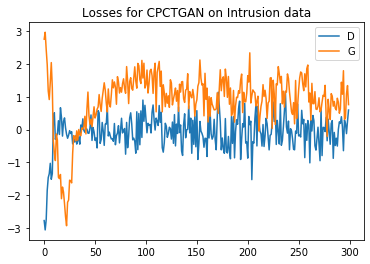

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure()
plt.plot(dloss)
plt.plot(gloss)
plt.legend(['D', 'G'])
plt.title('Losses for CPCTGAN on Intrusion data')
#plt.savefig('Original-CTGAN-Adult')

In [21]:
samples

,a,b,d,e,f,g,h,i,j,k,...,ah,aj,ak,al,am,an,ao,ap,aq,label
0,-0.156693,tcp,S0,-4.851859e+02,-15.010745,0.0,0.0,0.0,0.0,0.0,...,255.130608,1.000000,0.000000,-0.180114,0.000000,0.649355,0.269477,0.318627,0.544257,apache2.
1,0.286001,tcp,S3,4.227182e+02,13.350604,0.0,0.0,0.0,0.0,0.0,...,243.688149,0.934954,0.059284,-0.173158,0.000000,0.008637,0.000000,0.421906,0.000000,apache2.
2,2.032855,tcp,RSTR,1.445342e+03,5.609225,0.0,0.0,0.0,0.0,0.0,...,243.416069,0.019138,0.061389,-0.200125,0.000000,0.004958,0.000000,0.245643,0.396530,apache2.
3,-443.814379,tcp,RSTR,8.779978e+06,4.854925,0.0,0.0,0.0,0.0,0.0,...,253.153482,0.984161,0.010000,0.088558,0.000000,0.016318,0.019504,0.876111,0.332608,apache2.
4,0.214487,icmp,OTH,3.006300e+02,12.551514,0.0,0.0,0.0,0.0,0.0,...,4.706607,0.979959,0.066352,0.181421,0.000000,0.004483,0.000000,0.896316,0.000000,portsweep
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0.197163,icmp,SF,6.301154e+02,-1.294215,0.0,0.0,0.0,0.0,0.0,...,255.019322,0.991101,0.000000,0.866929,0.000000,0.000000,0.000000,0.000000,0.000000,smurf
199996,0.510369,tcp,SF,5.452047e+02,12.290918,0.0,0.0,0.0,0.0,0.0,...,254.335103,1.000000,0.015425,0.093439,0.000000,-0.001670,0.000000,0.000000,0.000000,apache2.
199997,852.141679,tcp,RSTR,1.248216e+03,15.574383,0.0,0.0,0.0,0.0,0.0,...,252.447918,0.973758,0.010000,0.069958,0.000000,0.005244,0.000000,0.115709,0.022203,apache2.
199998,1.280757,tcp,RSTR,1.010230e+03,5.955706,0.0,0.0,0.0,0.0,0.0,...,239.868081,0.921405,0.010000,-0.051952,0.000000,0.010734,0.018328,0.391364,0.357449,apache2.


In [22]:
# try using the Ruiwen's Encoder for ML utility and CTGAN transformer for GAN
str_cols= [ 'b', 'd', 'label']
num_cols = ['a','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z','aa','ab','ac','ad','af','ag','ah','aj','ak','al','am','an','ao','ap','aq']
dataframe = pd.DataFrame(samples.loc[:,str_cols])

one_hot_columns = pd.DataFrame()
for col_name, item in dataframe.iteritems():
    
    #print(col_name)
    #print(item)
    col = pd.get_dummies(item, prefix=col_name)
    one_hot_columns =pd.concat([one_hot_columns,col],axis=1)
one_hot_columns.head()  

,b_icmp,b_tcp,b_udp,d_OTH,d_REJ,d_RSTO,d_RSTR,d_S0,d_S1,d_S2,...,label_snmpgetattack,label_snmpguess,label_sqlattack,label_teardrop,label_udpstorm.,label_warezmaster,label_worm.,label_xlock,label_xsnoop,label_xterm.
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# entire data is concat of discrete and contiuous cols
fake_all = pd.concat([one_hot_columns,samples.loc[:,num_cols]],axis=1)
#fake_all.head()

# make sure cols of generated data has the same index sort 
fake_all = fake_all.reindex(intrusion_data.columns,axis=1, fill_value=0) # fill new cols with 0

#fake_all.shape

fake_all = fake_all.drop(columns=['label_smurf','label_neptune','label_snmpgetattack','label_mailbomb','label_guess_passwd','label_snmpguess','label_satan','label_warezmaster','label_back','label_mscan','label_apache2.','label_processtable','label_saint','label_portsweep','label_ipsweep','label_httptunnel','label_pod','label_nmap','label_buffer_overflow.','label_multihop','label_sendmail','label_named','label_ps','label_rootkit','label_xterm.','label_teardrop','label_land','label_xlock','label_xsnoop','label_ftp_write','label_phf','label_udpstorm.','label_perl','label_sqlattack','label_worm.','label_loadmodule','label_imap'])
fake_X = fake_all.rename(columns={'label_normal':'label'})

fake_X, fake_y = fake_X.drop(columns=["label"]),fake_X.loc[:,"label"]



In [26]:
# check the training data shape to agree with the original data (# of features/cols)
print('shape of the GAN generated train data: ',fake_X.shape)
print('shape of the GAN generated labels: ',fake_y.shape)
print('shape of the original test data: ',orig_X_test.shape)
print('number of events in the fake data: ', sum(fake_y))

shape of the GAN generated train data:  (200000, 52)
shape of the GAN generated labels:  (200000,)
shape of the original test data:  (93309, 52)
number of events in the fake data:  8716


In [27]:
# train a classifier on the CPCTGAN generated data
classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

print('ML scores for the GAN generated data:')
for name, clf in zip(names, classifiers):
    clf.fit(fake_X, fake_y)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)

ML scores for the GAN generated data:
Decision Tree Acc:  0.9401558263404387 f-1:  0.8511250933134263 AUC: 0.977656354439695
Linear SVM Acc:  0.19465432059072543 f-1:  0.32585136541428933 AUC: 0.9597929477223864
Random Forest Acc:  0.9553633625909612 f-1:  0.8921403599637447 AUC: 0.9914918788587084
Logistic Regression Acc:  0.8635608569377016 f-1:  0.47215887889215963 AUC: 0.9689794881748477
MLP Acc:  0.8912109228477424 f-1:  0.6239674013706242 AUC: 0.9702205035031641


In [20]:
fake_y.value_counts()

0    155168
1     44832
Name: label, dtype: int64

In [21]:
orig_y_test.value_counts()

0    75131
1    18178
Name: label, dtype: int64

### Train CTGAN on the same data

In [15]:
from ctgan import CTGANSynthesizer

In [19]:
GAN_train

,duration,protocol_type,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
215174,0,icmp,SF,1032,0,0,0,0,0,0,...,187,0.73,0.01,0.73,0.00,0.0,0.0,0.0,0.0,smurf
214746,0,tcp,SF,267,390,0,0,0,0,0,...,160,1.00,0.00,0.03,0.02,0.0,0.0,0.0,0.0,normal
151318,0,udp,SF,1,0,0,0,0,0,0,...,1,0.00,0.74,1.00,0.00,0.0,0.0,0.0,0.0,satan
278297,0,icmp,SF,520,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf
261219,0,icmp,SF,520,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192476,0,icmp,SF,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf
17730,0,icmp,SF,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf
28030,0,icmp,SF,1032,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf
277869,0,icmp,SF,520,0,0,0,0,0,0,...,255,1.00,0.00,1.00,0.00,0.0,0.0,0.0,0.0,smurf


'duration,protocol_type,flag,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,root_shell,su_attempted,num_root,num_file_creations,num_shells,num_access_files,num_outbound_cmds,is_host_login,is_guest_login,serror_rate,srv_serror_rate,rerror_rate,srv_rerror_rate,label'

In [22]:
# train CTGAN and generate fake data
# from synthesizer import CTGANSynthesizer
ctgan = CTGANSynthesizer(verbose=True)
ctgan.fit(GAN_train, discrete, epochs=300)

Epoch 1, Loss G: -2.3438,Loss D: -0.1776
Epoch 2, Loss G: -2.2153,Loss D: -0.6098


In [23]:
samples = ctgan.sample(200000)

In [24]:
# try using the Ruiwen's Encoder for ML utility and CTGAN transformer for GAN
str_cols= [ 'protocol_type', 'flag', 'label']
num_cols = ['duration','src_bytes','dst_bytes','land','wrong_fragment','urgent','hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations','num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count','serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate','dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate']
dataframe = pd.DataFrame(samples.loc[:,str_cols])

one_hot_columns = pd.DataFrame()
for col_name, item in dataframe.iteritems():
    
    #print(col_name)
    #print(item)
    col = pd.get_dummies(item, prefix=col_name)
    one_hot_columns =pd.concat([one_hot_columns,col],axis=1)
one_hot_columns.head()  

,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,flag_OTH,flag_REJ,flag_RSTO,flag_RSTR,flag_S0,flag_S1,flag_S2,...,label_snmpgetattack,label_snmpguess,label_sqlattack,label_teardrop,label_udpstorm.,label_warezmaster,label_worm.,label_xlock,label_xsnoop,label_xterm.
0,0,0,1,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
# entire data is concat of discrete and contiuous cols
fake_all = pd.concat([one_hot_columns,samples.loc[:,num_cols]],axis=1)
#fake_all.head()

# make sure cols of generated data has the same index sort 
fake_all = fake_all.reindex(intrusion_data.columns,axis=1, fill_value=0) # fill new cols with 0

#fake_all.shape

fake_all = fake_all.drop(columns=['label_smurf','label_neptune','label_snmpgetattack','label_mailbomb','label_guess_passwd','label_snmpguess','label_satan','label_warezmaster','label_back','label_mscan','label_apache2.','label_processtable','label_saint','label_portsweep','label_ipsweep','label_httptunnel','label_pod','label_nmap','label_buffer_overflow.','label_multihop','label_sendmail','label_named','label_ps','label_rootkit','label_xterm.','label_teardrop','label_land','label_xlock','label_xsnoop','label_ftp_write','label_phf','label_udpstorm.','label_perl','label_sqlattack','label_worm.','label_loadmodule','label_imap'])
fake_X = fake_all.rename(columns={'label_normal':'label'})

fake_X, fake_y = fake_X.drop(columns=["label"]),fake_X.loc[:,"label"]



In [26]:
# check the training data shape to agree with the original data (# of features/cols)
print('shape of the GAN generated train data: ',fake_X.shape)
print('shape of the GAN generated labels: ',fake_y.shape)
print('shape of the original test data: ',orig_X_test.shape)
print('number of events in the fake data: ', sum(fake_y))

shape of the GAN generated train data:  (200000, 52)
shape of the GAN generated labels:  (200000,)
shape of the original test data:  (93309, 52)
number of events in the fake data:  57884


In [27]:
# train a classifier on the CPCTGAN generated data
classifiers = [
    DecisionTreeClassifier(max_depth=5,random_state=0),
    SVC(kernel = 'linear', max_iter=1000, C=0.025, random_state=0, probability=True),
    RandomForestClassifier(n_estimators=200, random_state=0),
    LogisticRegression(max_iter=1000, random_state=0),
    MLPClassifier(alpha=1, max_iter=1000, random_state=0)]

print('ML scores for the GAN generated data:')
for name, clf in zip(names, classifiers):
    clf.fit(fake_X, fake_y)
    score = clf.score(orig_X_test, orig_y_test)
    y_pred = clf.predict(orig_X_test)
    Acc = accuracy_score(orig_y_test, y_pred)
    fscore = f1_score(orig_y_test, y_pred, average='binary')
    AUC = roc_auc_score(orig_y_test, clf.predict_proba(orig_X_test)[:, 1])
    print(name,'Acc: ', Acc, 'f-1: ', fscore, 'AUC:', AUC)

ML scores for the GAN generated data:
Decision Tree Acc:  0.9432101940863153 f-1:  0.8406459567557814 AUC: 0.9879786724638909
Linear SVM Acc:  0.8156447931067743 f-1:  0.10294117647058823 AUC: 0.961971616367371
Random Forest Acc:  0.9440568433913127 f-1:  0.8633078453964597 AUC: 0.9897834432614219
Logistic Regression Acc:  0.9254412757611806 f-1:  0.7906220844493935 AUC: 0.9695149961406978
MLP Acc:  0.9323109239194505 f-1:  0.8334300332296006 AUC: 0.9759709899981952
